In [1]:
import os

import astropy.coordinates as coord
from astropy.io import fits, ascii
import astropy.table as at
from astropy.time import Time
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import pymc3 as pm
import exoplanet.units as xu
import exoplanet as xo
import corner

from schwimmbad import MultiPool
import thejoker as tj
from twobody.transforms import get_m2_min

Load APOGEE data (copy-pasta from Table S2 in Thompson et al. 2019):

In [18]:
apogee_tbl = ascii.read(
    """6204.95544 -37.417 0.011
    6229.92499 34.846 0.010
    6233.87715 42.567 0.010""", 
    names=['HJD', 'rv', 'rv_err'])

apogee_data = tj.RVData(
    t=Time(apogee_tbl['HJD'] + 2450000, format='jd', scale='tcb'),
    rv=apogee_tbl['rv'] * u.km/u.s, 
    rv_err=apogee_tbl['rv_err'] * u.km/u.s)

Load TRES data (copy-pasta from Table S2 in Thompson et al. 2019):

In [20]:
tres_tbl = ascii.read(
    """8006.97517 0.000 0.075
    8023.98151 -43.313 0.075
    8039.89955 -27.963 0.045
    8051.98423 10.928 0.118
    8070.99556 43.782 0.075
    8099.80651 -30.033 0.054
    8106.91698 -42.872 0.135
    8112.81800 -44.863 0.088
    8123.79627 -25.810 0.115
    8136.59960 15.691 0.146
    8143.78352 34.281 0.087""", 
    names=['HJD', 'rv', 'rv_err'])

tres_data = tj.RVData(
    t=Time(tres_tbl['HJD'] + 2450000, format='jd', scale='tcb'),
    rv=tres_tbl['rv'] * u.km/u.s, 
    rv_err=tres_tbl['rv_err'] * u.km/u.s)

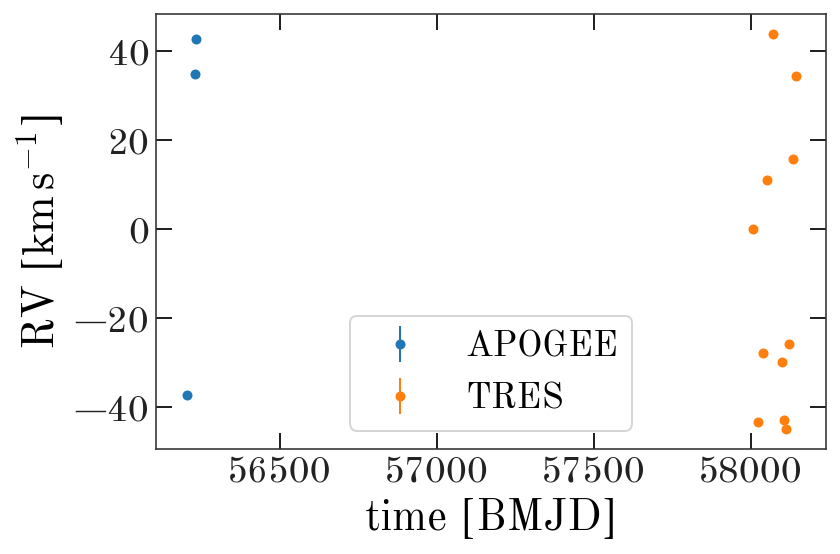

In [25]:
data = [apogee_data, tres_data]
for d, name in zip(data, ['APOGEE', 'TRES']):
    d.plot(color=None, label=name)
plt.legend(fontsize=18)

# Try running The Joker with just TRES data:

In [7]:
with pm.Model() as model:
    # Allow "jitter" / under-reported error-bars
    s = xu.with_unit(pm.Lognormal('s', -2, 1),
                     u.km/u.s)
    
    prior = tj.JokerPrior.default(
        P_min=32*u.day, P_max=128*u.day,
        sigma_K0=30*u.km/u.s, P0=1*u.year,
        sigma_v=25*u.km/u.s,
        s=s
    )

In [8]:
# Generate a large number of prior samples:
prior_samples = prior.sample(size=1_000_000)

In [9]:
# Run rejection sampling with The Joker:
with MultiPool() as pool:
    joker = tj.TheJoker(prior, pool=pool)
    samples = joker.rejection_sample(tres_data, prior_samples,
                                     max_posterior_samples=256)

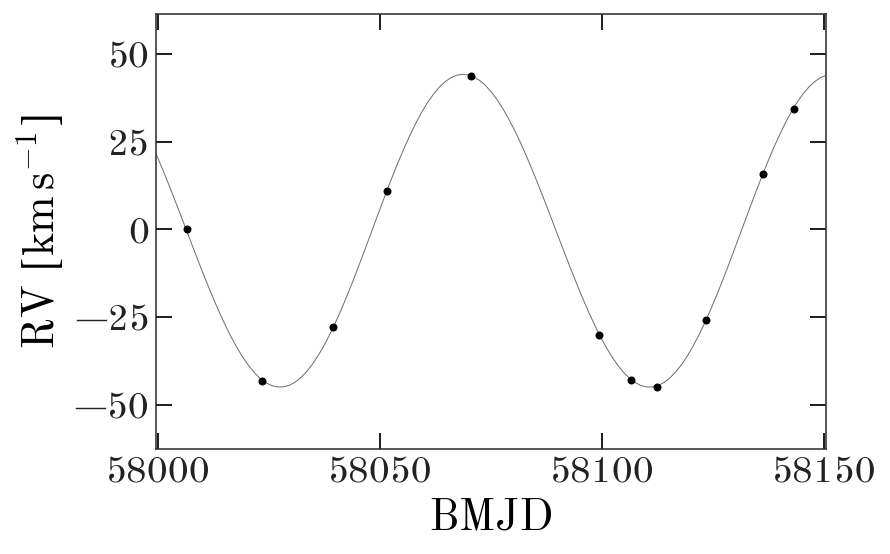

In [10]:
_ = tj.plot_rv_curves(samples, data=tres_data)

In [11]:
samples.tbl

P,e,omega,M0,s,K,v0
d,,rad,rad,km / s,km / s,km / s
float64,float64,float64,float64,float64,float64,float64
83.170340687727,0.007561487249288719,1.9079830732792349,3.4812782955981874,0.12707596153197329,-44.63992354388669,-0.509654997295866


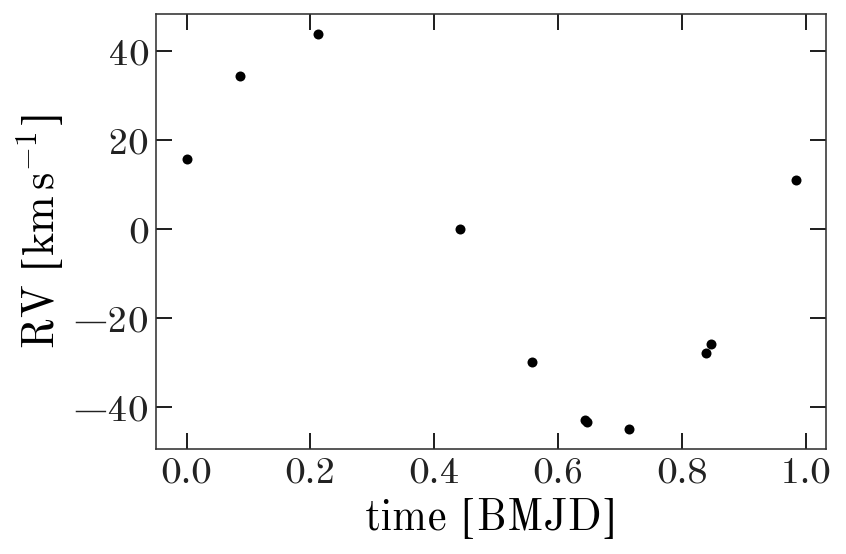

In [12]:
_ = tres_data.plot(phase_fold=samples['P'][0])

The Joker only returned one sample, so let's continue sampling with MCMC:

In [13]:
with prior.model:
    mcmc_init = joker.setup_mcmc(tres_data, samples)
    
    trace = pm.sample(
        tune=1000, draws=1000,
        start=mcmc_init,
        step=xo.get_dense_nuts_step(target_accept=0.95))

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [v0, K, P, omega, h, e, e_beta, e_alpha, s]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:24<00:00, 332.62draws/s]


In [14]:
pm.summary(trace, var_names=prior.par_names)

/Users/apricewhelan/anaconda/lib/python3.7/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
P,83.159000,0.058406,0.001025,83.045307,83.282359,3286.930680,0.999554
e,0.003631,0.002041,0.000048,0.000010,0.007198,1935.282552,1.001223
omega,0.089622,0.858201,0.021926,-2.087420,1.817741,1335.706450,1.000018
M0,1.667561,0.857788,0.021924,-0.503925,3.390206,1335.735570,1.000021
s,0.187033,0.075282,0.001989,0.050919,0.329281,1505.711612,1.002008
K,-44.615789,0.108193,0.002059,-44.813769,-44.378258,3097.563903,1.000291
v0,-0.473935,0.085162,0.001407,-0.650299,-0.312243,3478.369477,0.999850


We again find a shorter period, about 1/2 the period in Thompson et al. and much more eccentric:

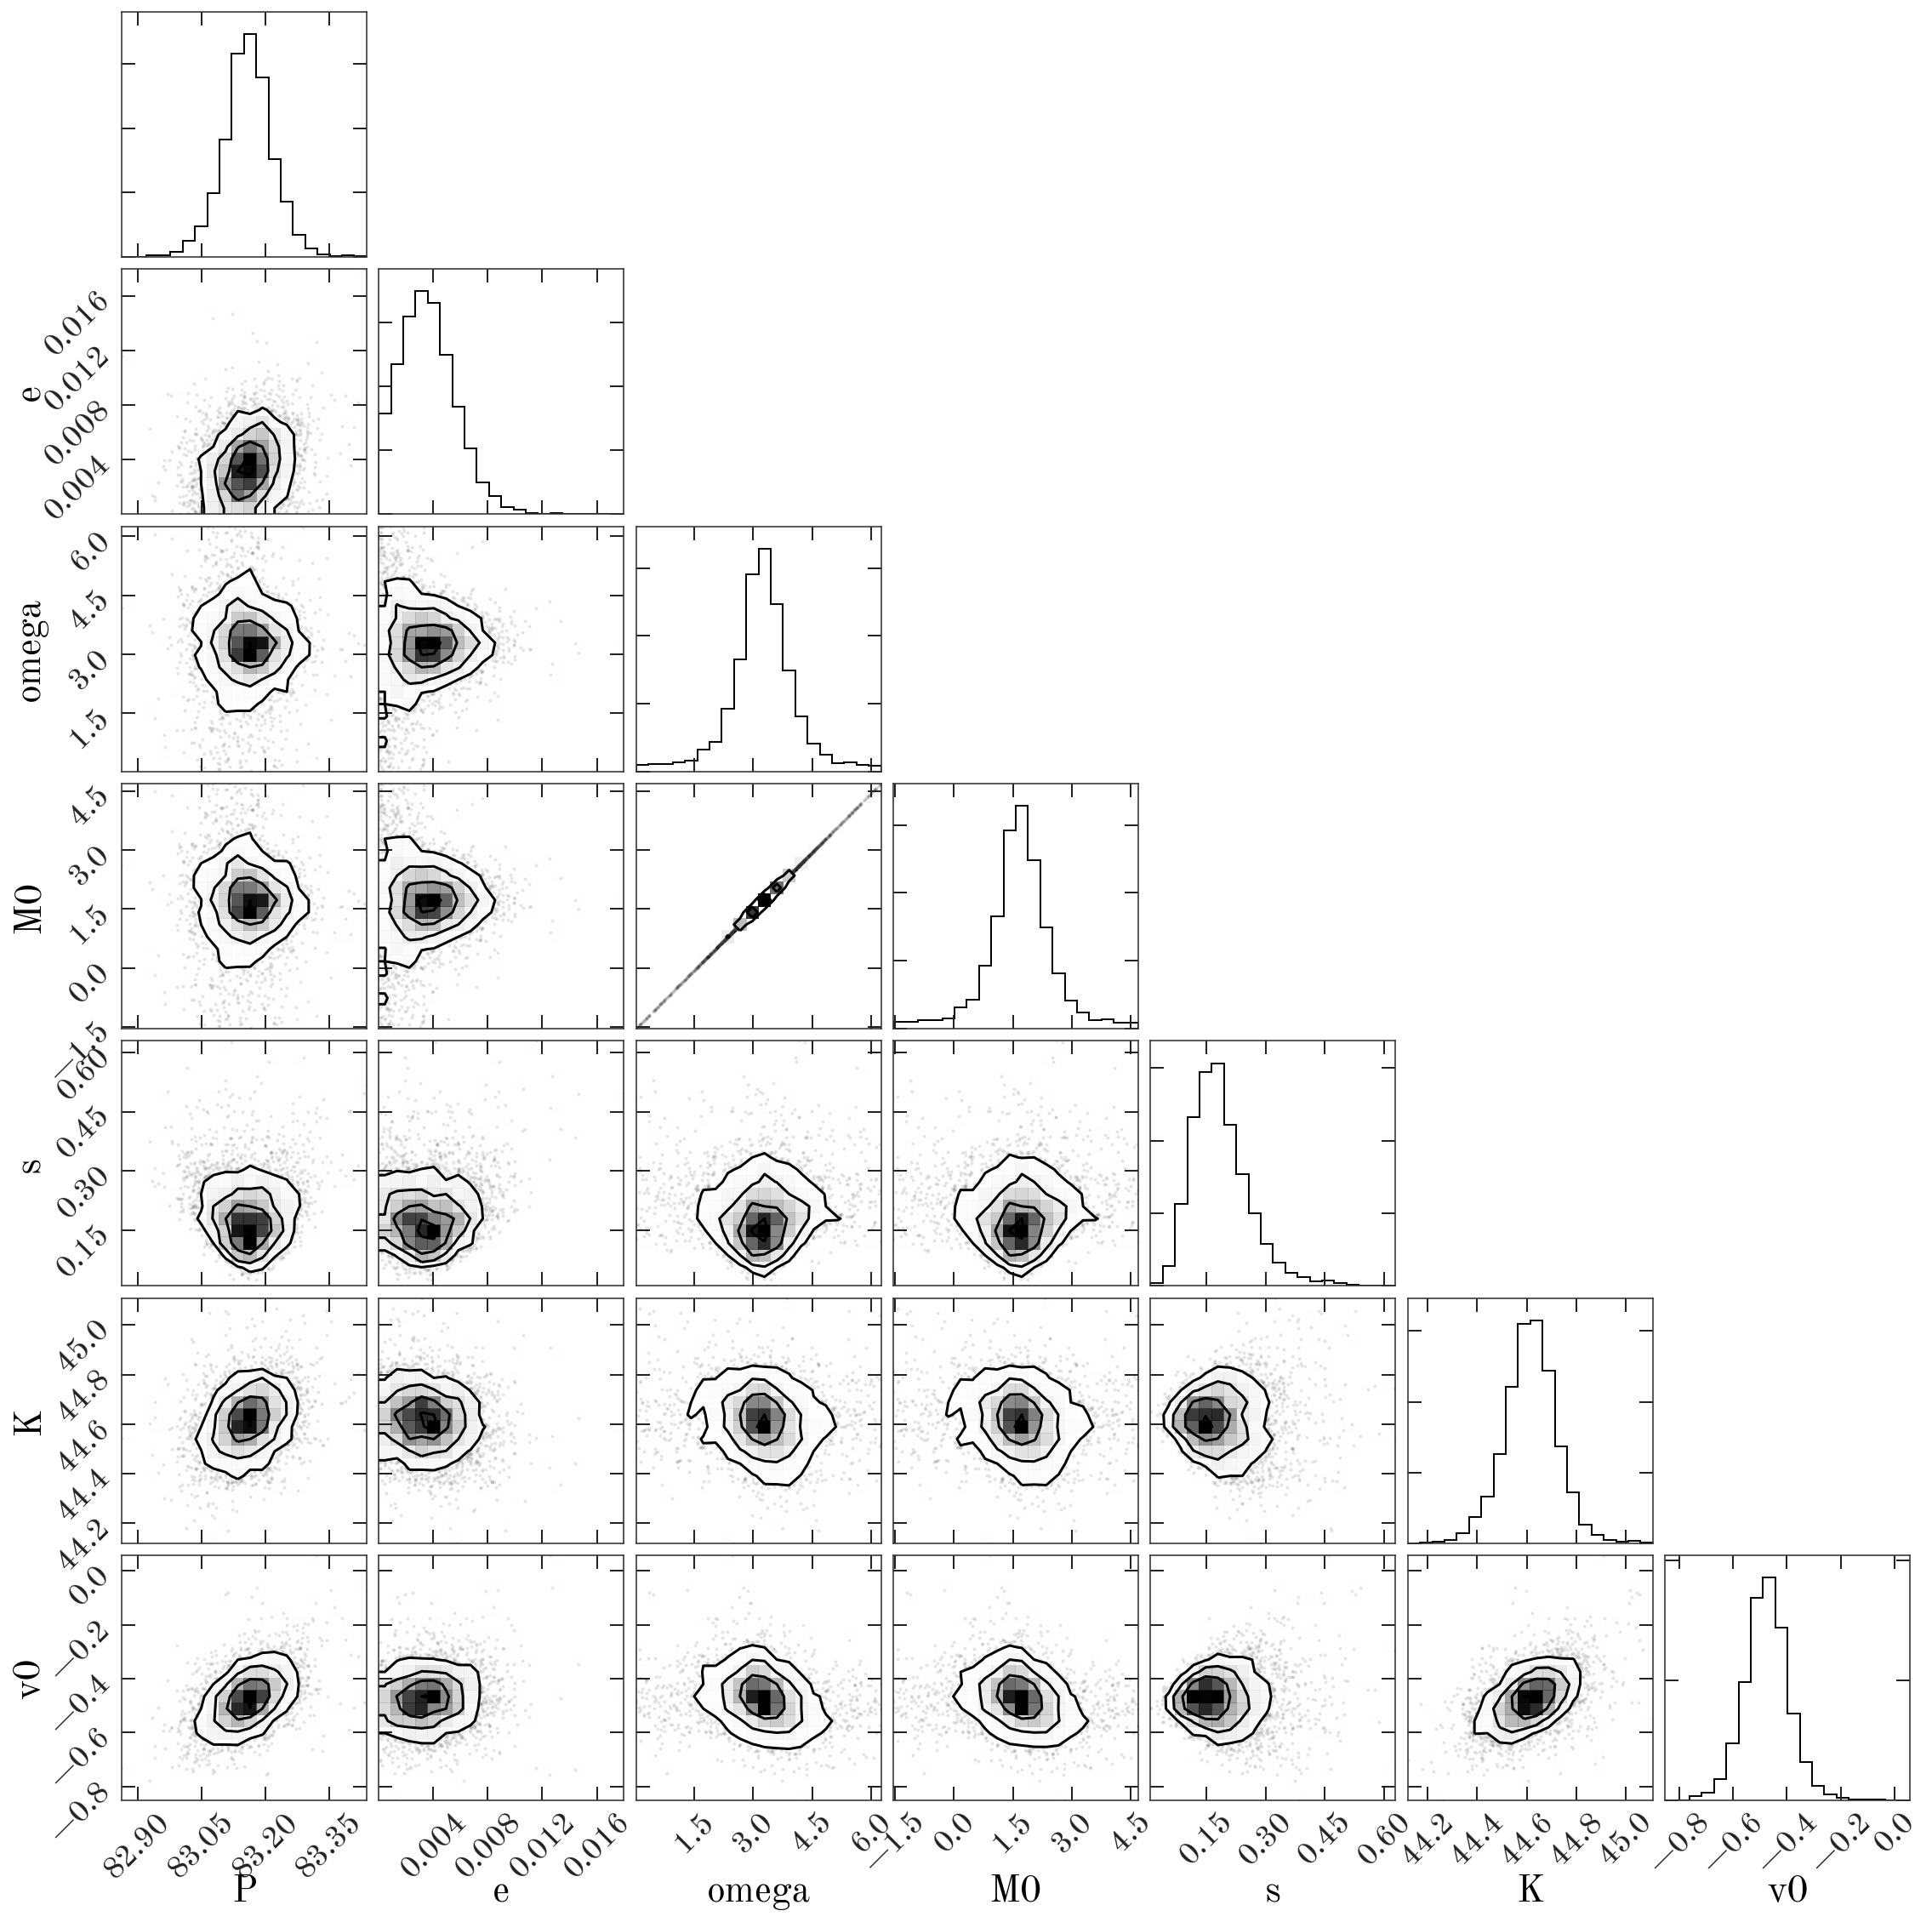

In [15]:
mcmc_samples = joker.trace_to_samples(trace, remove_constants=False)
mcmc_samples.wrap_K()
df = mcmc_samples.tbl.to_pandas()
_ = corner.corner(df)

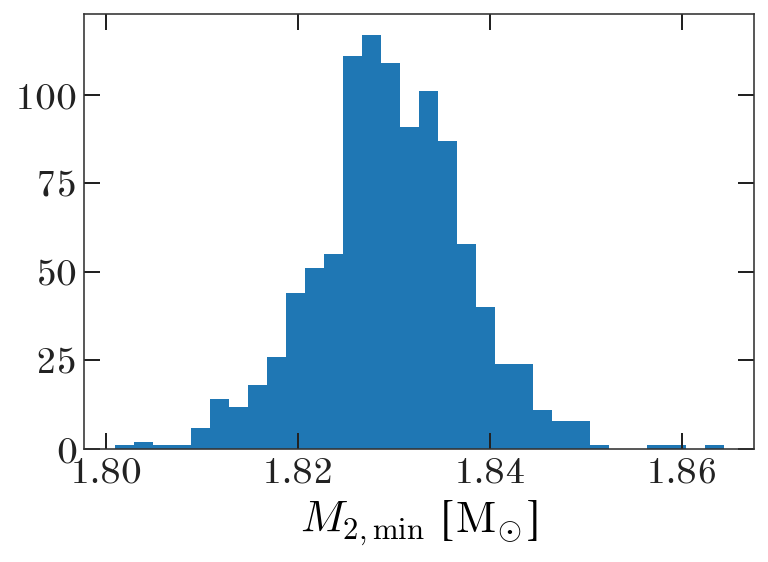

In [16]:
assumed_m1 = 1. * u.Msun
m2_mins = u.Quantity([get_m2_min(assumed_m1, mcmc_samples.get_orbit(i).m_f) 
                      for i in np.random.choice(len(mcmc_samples), 1024)])

plt.hist(m2_mins.to_value(u.Msun), bins=32);
plt.xlabel(rf'$M_{{2, {{\rm min}}}}$ [{u.Msun:latex_inline}]');

# Now try with TRES+APOGEE data:

In [192]:
data = [apogee_data, tres_data]

First just phase fold the full data on the previously determined period:

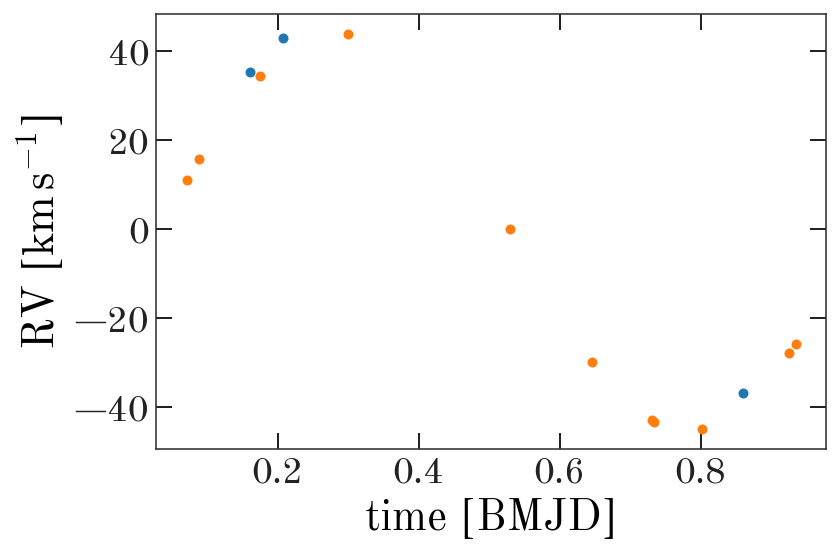

In [193]:
for d in data:
    _ = d.plot(color=None, phase_fold=np.mean(mcmc_samples['P']))

Here, we need to allow for an unknown constant velocity offset between TRES and APOGEE, included as a parameter `dv0_1` below. We also allow for a long-term velocity trend, just in case:

In [194]:
with pm.Model() as model:
    dv0_1 = xu.with_unit(pm.Normal('dv0_1', 0, 25.),
                         u.km/u.s)
    s = xu.with_unit(pm.Lognormal('s', -2, 1),
                     u.km/u.s)
    
    prior = tj.JokerPrior.default(
        P_min=32*u.day, P_max=128*u.day,
        sigma_K0=30*u.km/u.s, P0=1*u.year,
        sigma_v=[100*u.km/u.s,
                 0.1*u.km/u.s/u.day],
        poly_trend=2,
        v0_offsets=[dv0_1],
        s=s
    )
    
prior_samples = prior.sample(size=10_000_000)

In [195]:
# Run rejection sampling with The Joker:
with MultiPool() as pool:
    joker = tj.TheJoker(prior, pool=pool)
    samples = joker.rejection_sample(data, prior_samples,
                                     max_posterior_samples=256)

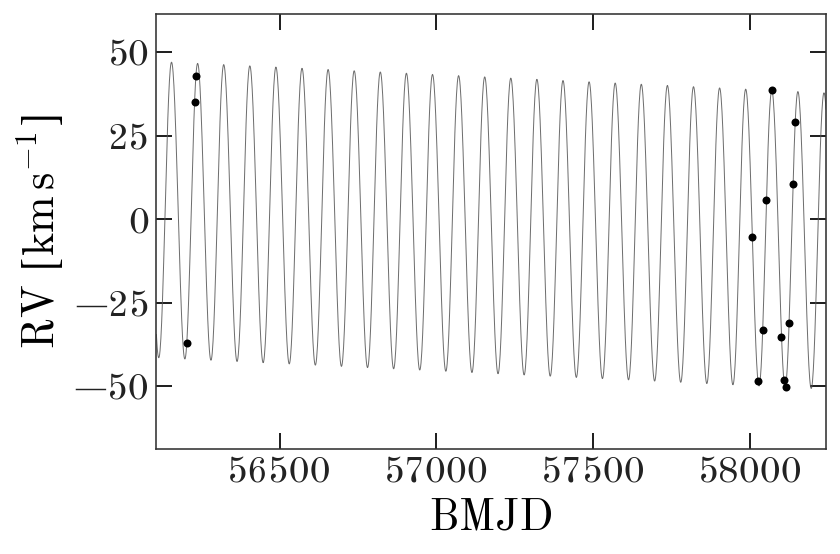

In [196]:
_ = tj.plot_rv_curves(samples, data=data)

In [197]:
samples.tbl

P,e,omega,M0,s,K,v0,dv0_1,v1
d,,rad,rad,km / s,km / s,km / s,km / s,km / (d s)
float64,float64,float64,float64,float64,float64,float64,float64,float64
83.16425643292212,0.016050859521549478,-1.5998466111174732,1.038763751429415,0.10888663019323847,44.28916176504475,2.453411043526821,5.198157933336985,-0.004409370057330918


Again, we get a shorter period, but now with an even larger eccentricity...

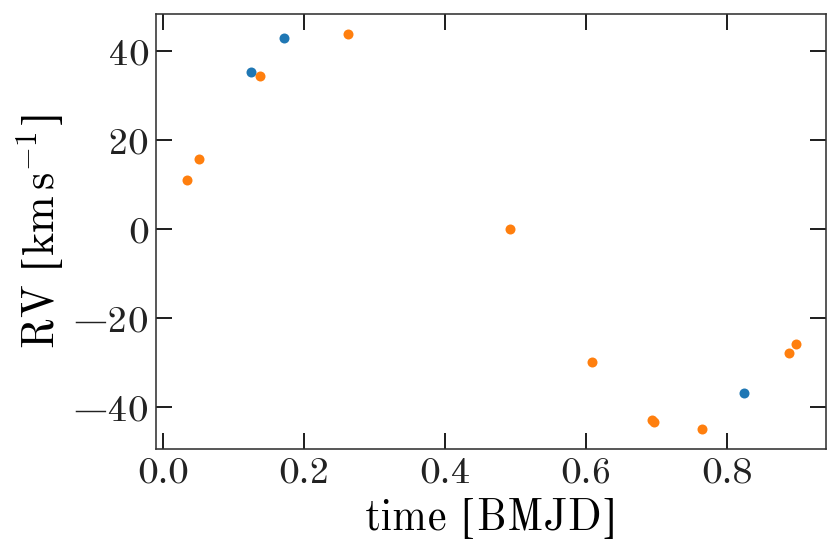

In [198]:
for d in data:
    _ = d.plot(color=None, phase_fold=samples['P'][0])

In [199]:
with prior.model:
    mcmc_init = joker.setup_mcmc(data, samples)
    
    trace = pm.sample(
        tune=1000, draws=1000,
        start=mcmc_init,
        step=xo.get_dense_nuts_step(target_accept=0.95))

Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [v1, v0, K, P, M0, omega, e, e_beta, e_alpha, s, dv0_1]
INFO:pymc3:NUTS: [v1, v0, K, P, M0, omega, e, e_beta, e_alpha, s, dv0_1]
Sampling 4 chains: 100%|██████████| 8000/8000 [03:36<00:00, 10.56draws/s]
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 7 divergences after tuning. Increase `target_acc

In [200]:
pm.summary(trace, var_names=prior.par_names)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
P,83.157520,0.014642,0.000279,83.129447,83.188152,2918.711795,0.999615
e,0.003728,0.002224,0.000054,0.000008,0.007691,1563.881186,1.000097
omega,-1.205828,2.055893,0.058856,-3.131957,3.002678,1323.289079,1.001674
M0,0.066947,0.949585,0.025938,-1.938205,2.301436,1112.098163,1.001981
s,0.217705,0.071508,0.002179,0.099275,0.359556,982.135375,1.001074
K,44.682565,0.103038,0.002312,44.483058,44.892425,2204.069746,1.002052
v0,2.677041,0.588134,0.010567,1.585677,3.927286,3103.725218,0.999803
v1,-0.000516,0.001956,0.000040,-0.004277,0.003496,2363.270176,1.000334
dv0_1,-2.174650,3.643285,0.074082,-9.686850,4.816589,2295.866692,1.000286


In [201]:
mcmc_samples = joker.trace_to_samples(trace)
# mcmc_samples.wrap_K()

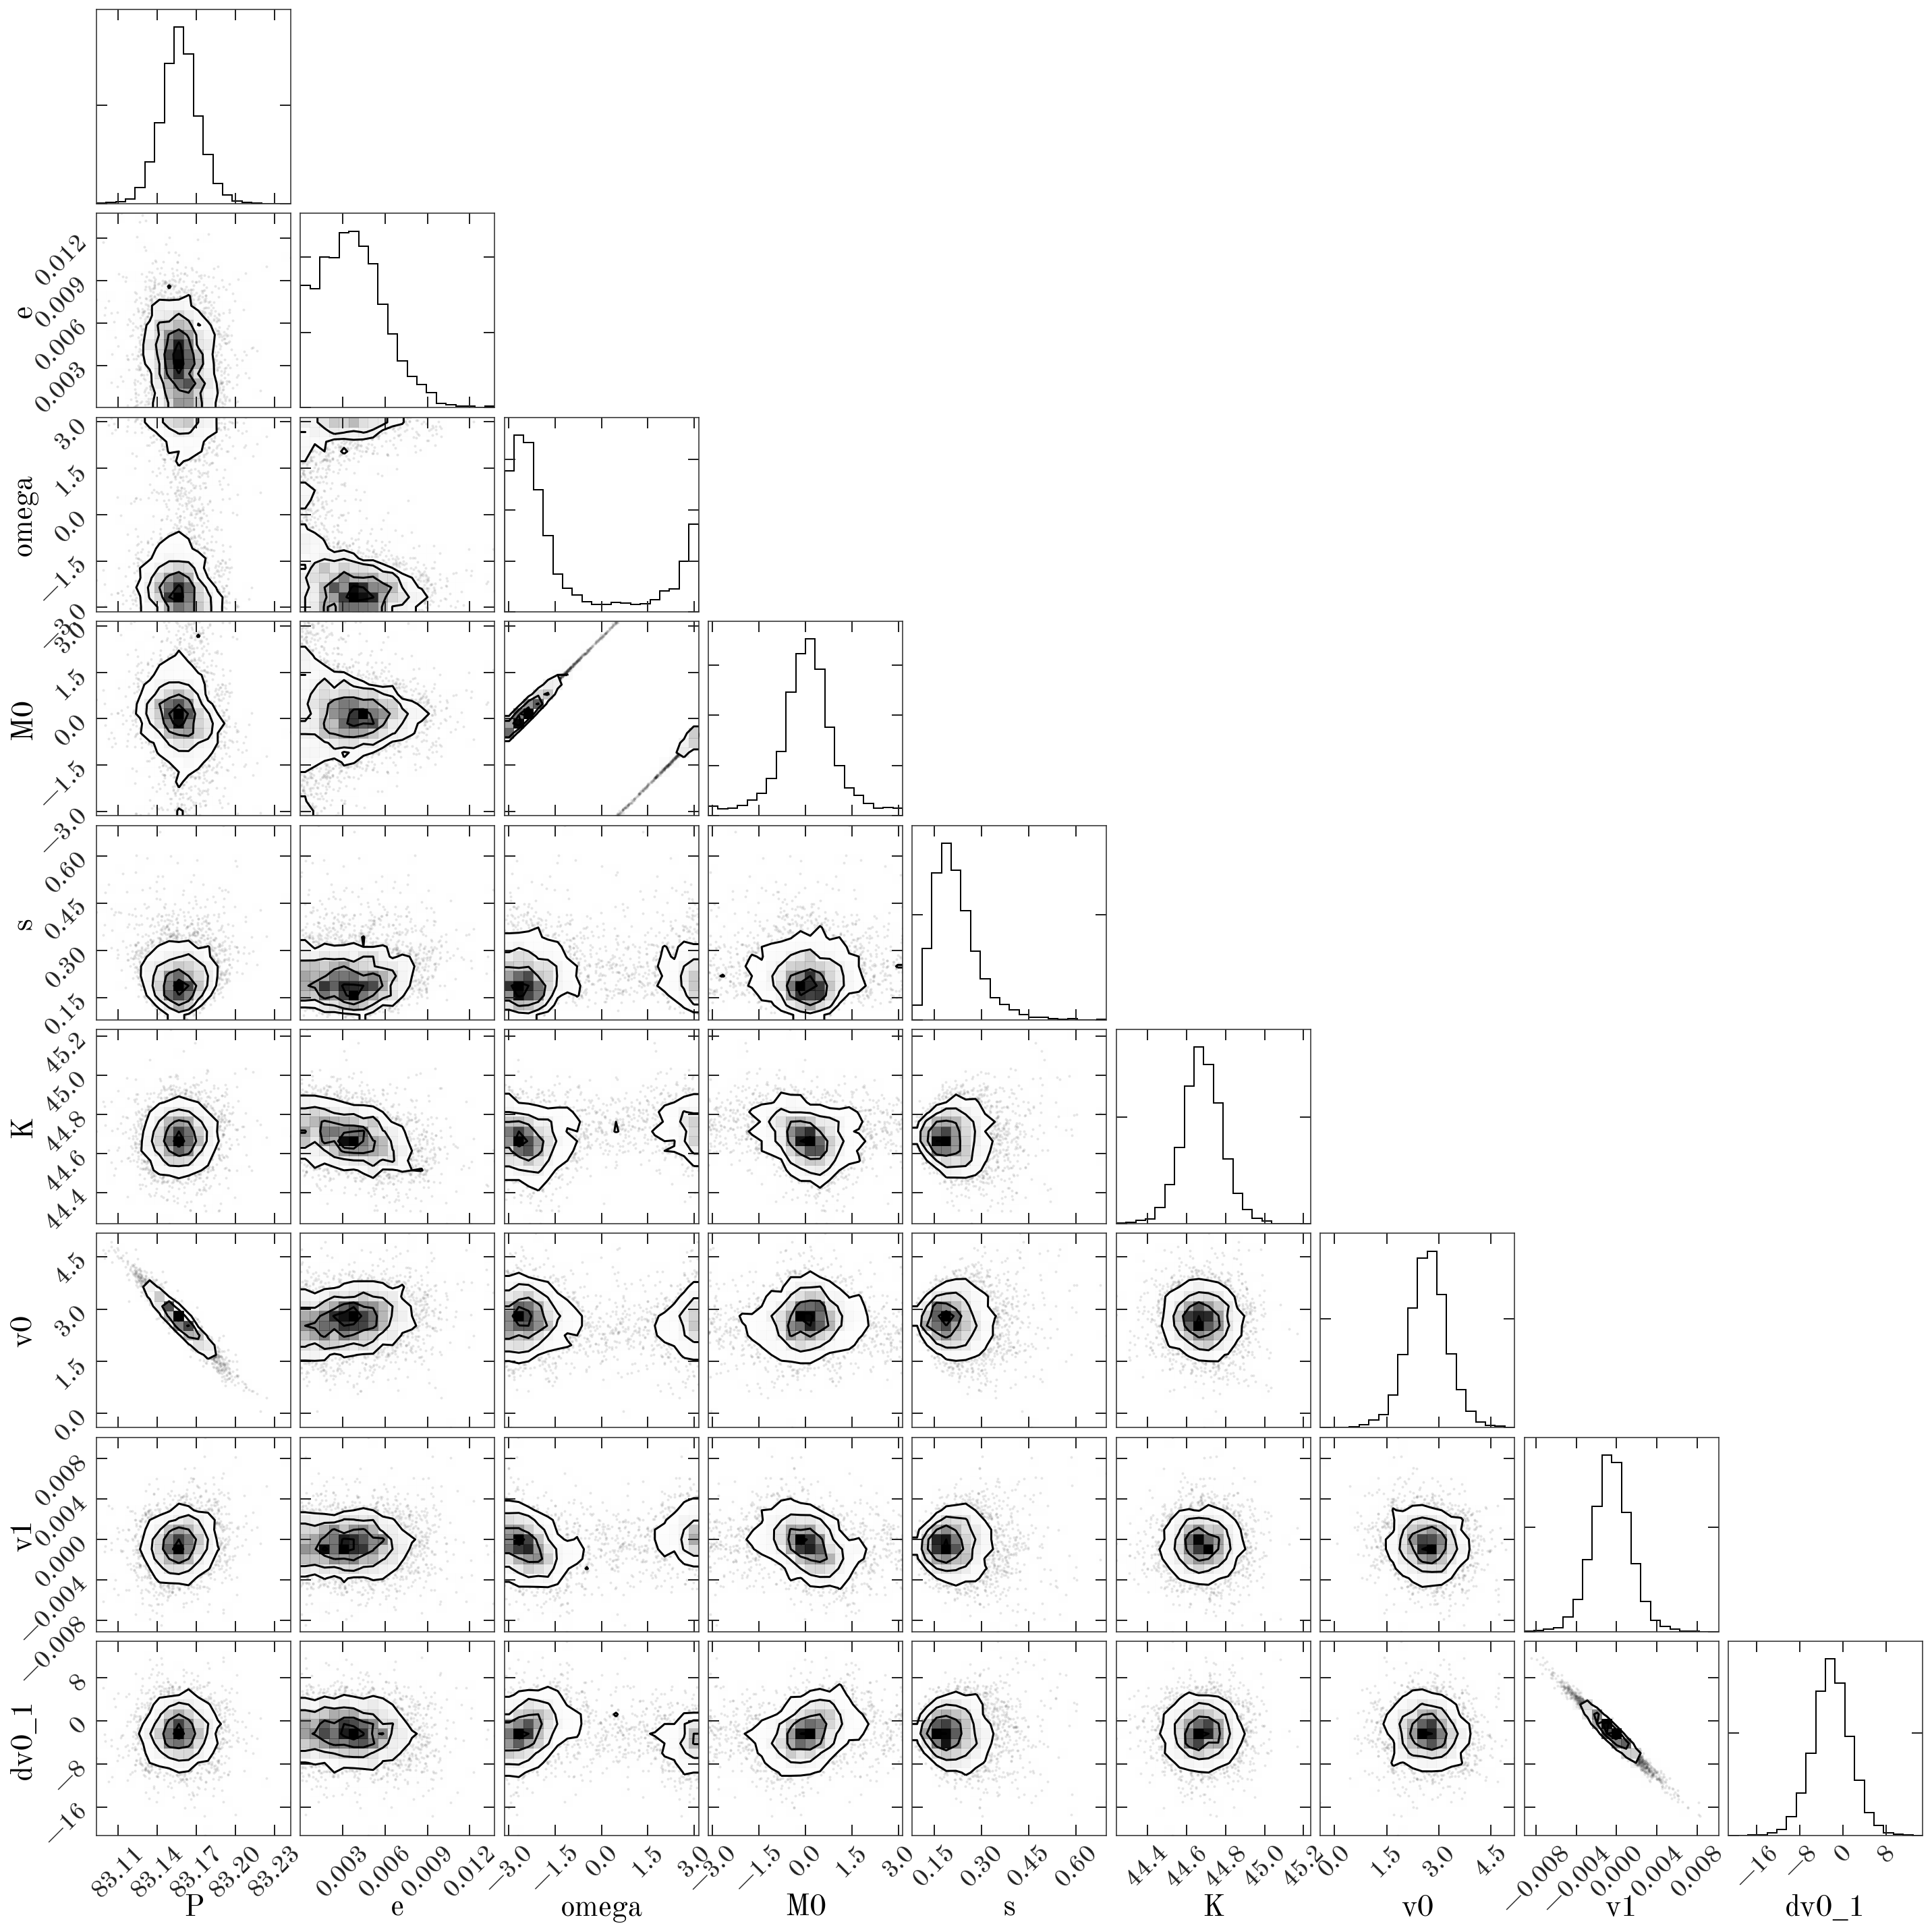

In [202]:
df = mcmc_samples.tbl.to_pandas()
_ = corner.corner(df)

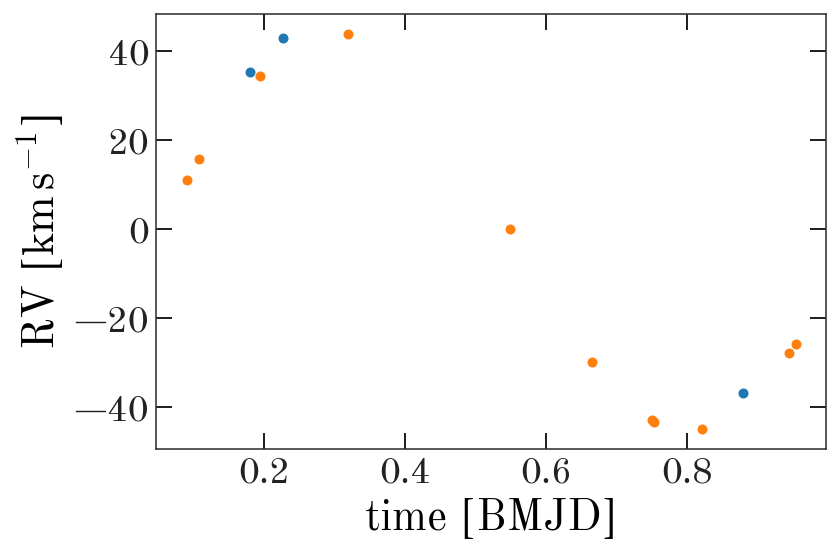

In [203]:
P = mcmc_samples.mean()['P'][0]
for d in data:
    _ = d.plot(color=None, phase_fold=P)

---

### APOGEE only

In [6]:
with pm.Model() as model:
    # Allow "jitter" / under-reported error-bars
    s = xu.with_unit(pm.Lognormal('s', -2, 1),
                     u.km/u.s)
    
    prior = tj.JokerPrior.default(
        P_min=32*u.day, P_max=128*u.day,
        sigma_K0=30*u.km/u.s, P0=1*u.year,
        sigma_v=100*u.km/u.s,
        s=s
    )

In [8]:
# Generate a large number of prior samples:
prior_samples = prior.sample(size=1_000_000)

# Run rejection sampling with The Joker:
with MultiPool() as pool:
    joker = tj.TheJoker(prior, pool=pool)
    samples = joker.rejection_sample(apogee_data, prior_samples,
                                     max_posterior_samples=1024)

In [9]:
samples

<JokerSamples [P, e, omega, M0, s, K, v0] (610 samples)>

In [10]:
samples.wrap_K()

In [13]:
assumed_m1 = 1. * u.Msun
m2_mins = u.Quantity([get_m2_min(assumed_m1, samples.get_orbit(i).m_f) 
                      for i in np.random.choice(len(samples), min(1024, len(samples)), replace=False)])

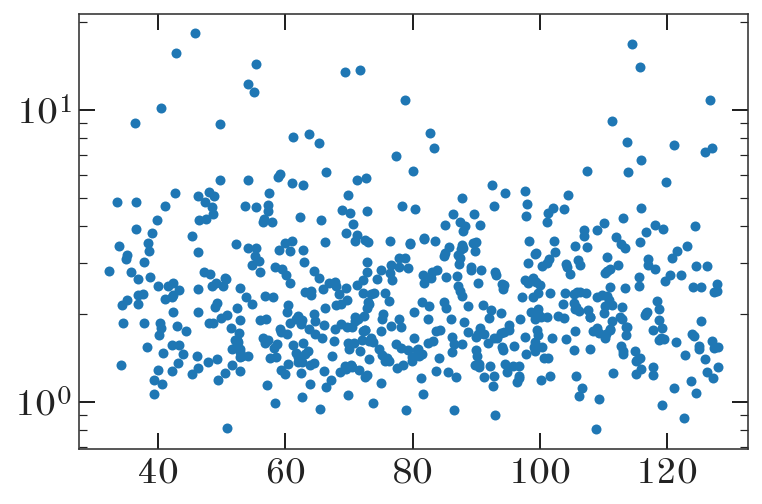

In [15]:
plt.plot(samples['P'].value,
         m2_mins.value,
         marker='o', ls='none')
plt.yscale('log')